# load best model and evaluation

In [20]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
from torch.utils.data import Dataset
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import os

In [21]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence

        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))

    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """

        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

############################################################################
# Any change about model should be here [interaction_type]
############################################################################
class LogisticRegressionPyTorch(nn.Module):
    """
    Logistic regression classification model
    Model would change according to interaction_type
    """
    def __init__(self, vocab_size, emb_dim, n_out, interaction_type):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        """
        super(LogisticRegressionPyTorch, self).__init__()

        # 1. Embedding
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        # 2. Logistic Regression
        # double embedding dimension if we concat hypo's and prem's embedding
        if interaction_type == 'concat':
            emb_dim *= 2
        self.linear = nn.Linear(emb_dim, n_out)

    def forward(self, data_hypo, length_hypo, data_prem, length_prem, interaction_type):
        """
        @param data_hypo: matrix of size (batch_size, max_sentence_length).
        @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data_hypo.
        @param data_prem: matrix of size (batch_size, max_sentence_length).
        @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data_prem.
        @param interaction_type: [sum. hadamart, concat]
        """
        out_hypo = self.embed(data_hypo)
        out_prem = self.embed(data_prem)

        out_hypo = torch.sum(out_hypo, dim=1)
        out_prem = torch.sum(out_prem, dim=1)

        out_hypo /= length_hypo.view(length_hypo.size()[0],1).expand_as(out_hypo).float()
        out_prem /= length_prem.view(length_prem.size()[0],1).expand_as(out_prem).float()

        # interaction
        # 1. sum
        # 2. Hadamard product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if interaction_type == 'concat':
            out = torch.cat((out_hypo,out_prem),1)
        if interaction_type == 'sum':
            out = torch.add(out_hypo, out_prem)
        if interaction_type == 'hadamard':
            out = out_hypo * out_prem

        # return logits
        out = self.linear(out.float())
        return out

def build_vocab(hypo_tokens, prem_tokens, max_vocab_size):

    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices

    hypo_token_counter = Counter(hypo_tokens)
    prem_token_counter = Counter(prem_tokens)

    all_tokens_counter = hypo_token_counter + prem_token_counter

    vocab, count = zip(*all_tokens_counter.most_common(max_vocab_size))

    #print(all_tokens_counter.most_common(MAX_VOCAB_SIZE))

    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab))))
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []


    #print("collate batch: ", batch)
    #batch[0][0] = batch[0][0][:max_sentence_length_prem]
    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=0)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=0)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list),torch.LongTensor(label_list)]

# Function for testing the model
def test_model(data_loader, model, interaction_type):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()

    for i, (data_hypo, lengths_hypo, data_prem, lengths_prem, labels) in enumerate(data_loader):
        outputs = model(data_hypo, lengths_hypo, data_prem, lengths_prem, interaction_type)
        #compute loss
        loss = criterion(outputs, labels)
        #compute acc
        outputs_softmax = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total), loss.item()

class NeuralNetworkPytorch(nn.Module):
    """
    NeuralNetwork classification model
    Model would change according to interaction_type

    1st hidden layer: 90 neurons
    2nd hidden layer: 90 neurons
    """
    def __init__(self, vocab_size, emb_dim, n_out, interaction_type):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding
        @param n_out: size of the class.
        """
        super(NeuralNetworkPytorch, self).__init__()

        # 1. Embedding
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        # 2. an affine operation: y=Wx+b
        # double embedding dimension if we concat hypo's and prem's embedding
        if interaction_type == 'concat':
            emb_dim = 2 * emb_dim
        self.hidden_1= nn.Linear(emb_dim,90)
        self.hidden_2=nn.Linear(90, 90)
        self.output = nn.Linear(90, n_out)

    def forward(self, data_hypo, length_hypo, data_prem, length_prem, interaction_type):
        """
            @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in the data_prem.
            @param interaction_type: [sum. hadamart, concat]
            """
        # word embedding
        out_hypo = self.embed(data_hypo)
        out_prem = self.embed(data_prem)
        # combine to sentence
        out_prem = torch.sum(out_prem, dim=1)
        out_hypo = torch.sum(out_hypo, dim=1)
        out_prem /= length_prem.view(length_prem.size()[0], 1).expand_as(out_prem).float()
        out_hypo /= length_hypo.view(length_hypo.size()[0], 1).expand_as(out_hypo).float()

        # interaction
        # 1. sum
        # 2. Hadamard product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if interaction_type == 'concat':
            out = torch.cat((out_hypo,out_prem),1)
        if interaction_type == 'sum':
            out = torch.add(out_hypo, out_prem)
        if interaction_type == 'hadamard':
            out = out_hypo * out_prem

        out = self.hidden_1(out.float())
        out = F.relu(out)
        out = self.hidden_2(out)
        out = F.relu(out)
        out = self.output(out)
        return out

In [22]:
######################################################
## Hyper paramter of the best model
max_vocab_size = 10000
emb_dim = 50
interaction_type= "hadamard"

In [23]:
######################################################
BATCH_SIZE = 10240 # this is chosen to be super big as I want to validate all data in one time
######################################################
# save index 0 for unk and 1 for pad
global PAD_IDX ,UNK_IDX
UNK_IDX = 0
PAD_IDX = 1


######################################################
# read data
######################################################
# # Tokenizing be done
folder = './all_data_pickle/'
hypo_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))
all_hypo_data_tokens_train = pkl.load(open(folder+"all_hypo_data_tokens_train.p", "rb"))
all_prem_data_tokens_train = pkl.load(open(folder+"all_prem_data_tokens_train.p", "rb"))
all_hypo_data_tokens_val = pkl.load(open(folder+"all_hypo_data_tokens_val.p", "rb"))
all_prem_data_tokens_val = pkl.load(open(folder+"all_prem_data_tokens_val.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

# # Vocabulary

token2id, id2token = build_vocab(all_hypo_data_tokens_train, all_prem_data_tokens_train, max_vocab_size)
hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)


# # PyTorch DataLoader
max_sentence_length = 20
# trim dataset
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)
# seperate dataset into different batch
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

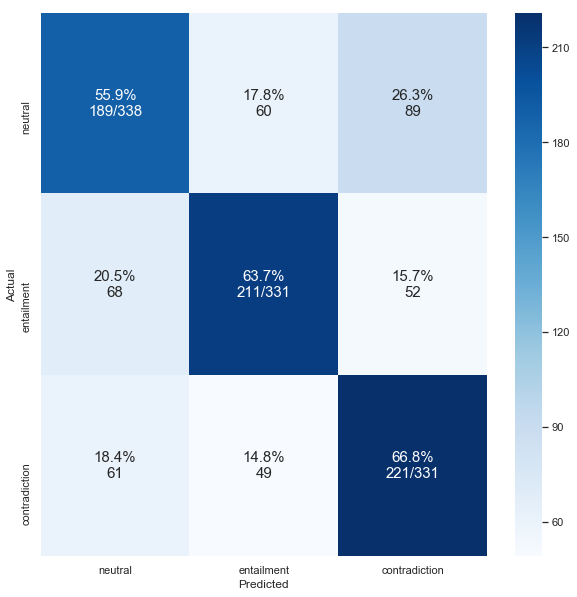

In [86]:
# reference of heatmap:https://www.kaggle.com/agungor2/various-confusion-matrix-plots
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax, annot_kws={"size": 15})
    plt.savefig('cm_{}.eps'.format(title))
    
    
plot_cm(y_true, y_pred)

### logistics model

In [87]:
######################################################
## Hyper paramter of the best model
max_vocab_size = 10000
emb_dim = 50
interaction_type= "hadamard"
token2id, id2token = build_vocab(all_hypo_data_tokens_train, all_prem_data_tokens_train, max_vocab_size)
hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)

In [88]:
################################################
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
################################################
# # Initialize Model
model = LogisticRegressionPyTorch(len(id2token), emb_dim, len(set(label_index_val)), interaction_type)
best_model_save = './3_2/best_checkpoint4_log.tar'
checkpoint = torch.load(best_model_save)
# load the pretrained model
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

**NOTE** len(hypo_data_indices_val)< batch_size so validation is done in one batch

In [89]:
acc = 0
model.eval()
for i, (data_hypo, lengths_hypo, data_prem, lengths_prem, labels) in enumerate(val_loader):
    print(i)
    outputs = model(data_hypo, lengths_hypo, data_prem, lengths_prem, interaction_type)
    # Compute loss
    loss = criterion(outputs,labels)
    # Compute acc
    outputs_softmax = F.softmax(outputs, dim=1)
    predicted = outputs_softmax.max(1, keepdim=True)[1]
    y_pred = np.array([a[0] for a in predicted.numpy()])
    y_true = labels.numpy()
    acc = accuracy_score(y_true, y_pred)

0


In [90]:
target_names = ['neutral', 'entailment', 'contradiction']
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

      neutral       0.59      0.56      0.58       338
   entailment       0.66      0.64      0.65       331
contradiction       0.61      0.67      0.64       331

    micro avg       0.62      0.62      0.62      1000
    macro avg       0.62      0.62      0.62      1000
 weighted avg       0.62      0.62      0.62      1000



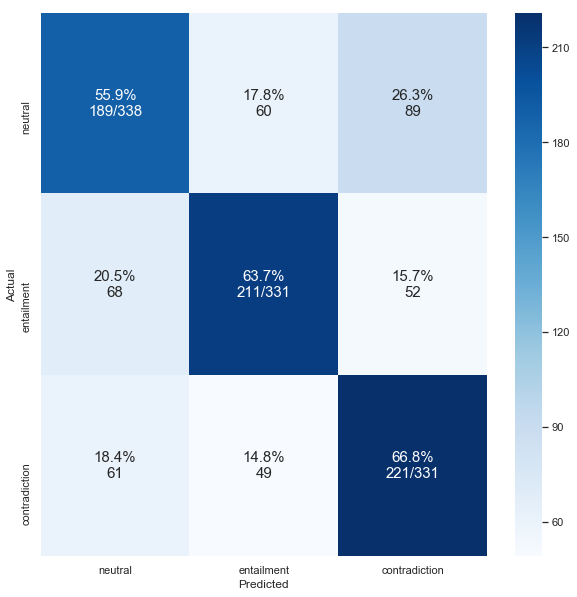

In [91]:
title = '10000_50_hadamard_logistic'
plot_cm(y_true, y_pred)
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### nn model

In [97]:
######################################################
## Hyper paramter of the best model

max_vocab_size = 50000
emb_dim = 50
interaction_type= "concat"
token2id, id2token = build_vocab(all_hypo_data_tokens_train, all_prem_data_tokens_train, max_vocab_size)
hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)

In [98]:
################################################
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
################################################
# # Initialize Model
model = NeuralNetworkPytorch(len(id2token), emb_dim, len(set(label_index_val)), interaction_type)
best_model_save = './3_2/best_checkpoint4_nn.tar'
checkpoint = torch.load(best_model_save)
# load the pretrained model
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

**NOTE** len(hypo_data_indices_val)< batch_size so validation is done in one batch

In [99]:
acc = 0
model.eval()
for i, (data_hypo, lengths_hypo, data_prem, lengths_prem, labels) in enumerate(val_loader):
    print(i)
    outputs = model(data_hypo, lengths_hypo, data_prem, lengths_prem, interaction_type)
    # Compute loss
    loss = criterion(outputs,labels)
    # Compute acc
    outputs_softmax = F.softmax(outputs, dim=1)
    predicted = outputs_softmax.max(1, keepdim=True)[1]
    y_pred = np.array([a[0] for a in predicted.numpy()])
    y_true = labels.numpy()
    acc = accuracy_score(y_true, y_pred)

0


In [100]:
target_names = ['neutral', 'entailment', 'contradiction']
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

      neutral       0.62      0.62      0.62       338
   entailment       0.66      0.70      0.68       331
contradiction       0.66      0.63      0.65       331

    micro avg       0.65      0.65      0.65      1000
    macro avg       0.65      0.65      0.65      1000
 weighted avg       0.65      0.65      0.65      1000



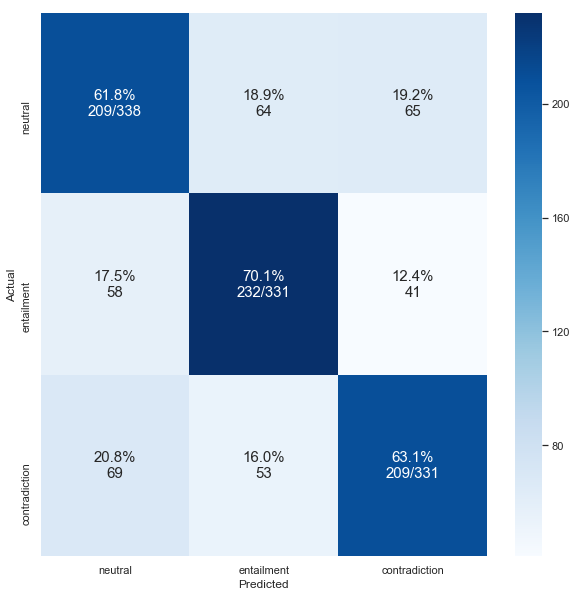

In [102]:
title = '10000_50_concat_nn'
plot_cm(y_true, y_pred)